## Tensorboard

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
! del /q %TMP%\.tensorboard-info\*

The system cannot find the file specified.


In [2]:
%tensorboard --logdir logs/scalars --host localhost

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy import ndimage, misc

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from skimage.transform import resize
import pylab
import pydicom as pyd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from skimage import exposure
def dcmchange(orig,clahe,mask) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = mask[:,:]
    return new

## Read Data

In [6]:
p = Path("dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':1, 'Heart':0,
               'Intra': 3, 'No Finding': 1, 'TB': 5, 'Pneumonia' : 6}
count = 0

heart_images = []
normal_images = []
heart_labels = []
normal_labels = []

count_normal = 0
count_heart = 0

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'Heart' or label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)
#             print(target)
            pic = pyd.read_file(target)
    #         pic_dir.append(pic)
            pic_r = np.array(pic.pixel_array)
    #         print(pic_r.shape)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)

            if label == 'Heart' :
                heart_images.append(resized_img2)
                heart_labels.append(labels_dict[label])
    #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_heart+=1
            elif label == 'No Finding' :
                normal_images.append(resized_img2)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 500 or count_heart == 500 : 
                break

        count_normal = 0
        count_heart = 0


## Test/Train

In [7]:
heart_images = np.array(heart_images, dtype=np.float32) #heart_images
heart_labels = np.array(heart_labels)
normal_images = np.array(normal_images, dtype=np.float32) #normal_images
normal_labels = np.array(normal_labels)

In [8]:
print("number of sample Heart: {}".format(len(heart_images)))
print("number of sample No Finding: {}".format(len(normal_images)))

number of sample Heart: 500
number of sample No Finding: 500


In [6]:
heart_images[1].shape

(224, 224, 3)

In [7]:
np.max(heart_images[400])

1.0

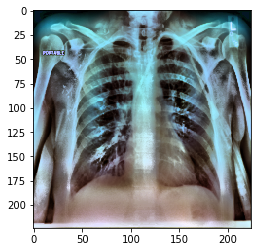

In [8]:
plt.imshow(heart_images[1])

## Feature

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# from tensorflow.keras.applications import VGG16

## Model

In [41]:
def cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 50
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
        
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(128, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=1, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
#     print(fpr)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\heart\\vgg16\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [48]:
from tensorflow.keras.applications import VGG19
def vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 50
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg19_model = VGG19(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg19_model.layers:
        layer.trainable = False
        
    new_model = vgg19_model.output
    new_model = AveragePooling2D(pool_size=(4, 4))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg19_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
#     print(fpr)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\heart\\vgg19\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [25]:
from tensorflow.keras.applications import DenseNet121
def dense_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    dense_model = DenseNet121(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in dense_model.layers:
        layer.trainable = False
        
    new_model = dense_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(128, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=dense_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=1, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
#     print(fpr)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\heart\dense\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

## Confusion Matrix

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report 
def confusion(y_test,pred) :
    cm_plot_labels = ['Finding', 'Normal']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
#     plot_confusion_matrix(confusion_mat1, cm_plot_labels, title='Confusion Matrix')
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=cm_plot_labels))
    

## ROC

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [17]:
def roc(fpr_recv,tpr_recv,acc_recv,num) :

    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         print(len(fpr_use))
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    std_auc = np.std(acc_recv)
    tprs = []
#     auc = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(num):
        tprs.append(np.interp(mean_fpr, fpr_recv[i], tpr_recv[i]))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    print(type(mean_fpr))
    print(type(mean_tpr))
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='black', 
             label='AUC Fold Average: %0.4f $\pm$ %0.2f' %(mean_auc, std_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Run

In [18]:
def AllinOne(other, normal,text) :
    stck_prob = []
    dis = 0
    #Set Test
    X_test = []
    y_test = []
    other_img = []
    normal_img = []
    for i in range(len(normal)) :
        if i >= 8 * len(normal) / 10 :
            X_test.append(normal[i])
            y_test.append(1)
        else :
            normal_img.append(normal[i])
    for i in range(len(other)) :
        if i >= 8 * len(other) / 10 :
            X_test.append(other[i])
            y_test.append(0)
        else :
            other_img.append(other[i])
    #Set Data
    for k in range(5):
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print(dis)
#         print(((8-dis) * len(normal)),((10-dis) * len(normal)))
        for i in range(len(normal_img)) :
            if i >= (8-dis) * len(normal_img) / 10 and i < (10-dis) * len(normal_img) / 10  :
                X_val.append(normal_img[i])
                y_val.append(1)
            else :
                X_train.append(normal_img[i])
                y_train.append(1)
        for i in range(len(other_img)) :
            if i >= (8-dis) * len(other_img) / 10 and i < (10-dis) * len(other_img) / 10  :
                X_val.append(other_img[i])
                y_val.append(0)
            else :
                X_train.append(other_img[i])
                y_train.append(0)
        #add dis
        dis = dis + 2
        #data
        y_train_s = np.array(y_train)
        X_train_s = np.array(X_train, dtype=np.float32) #train_images
        y_test_s = np.array(y_test)
        X_test_s = np.array(X_test, dtype=np.float32) #test_images
        y_val_s = np.array(y_val)
        X_val_s = np.array(X_val, dtype=np.float32) #val_images
        
        print("number of sample Train: {}".format(len(X_train_s)))
        print("number of sample Test: {}".format(len(X_test_s)))
        print("number of sample Val: {}".format(len(X_val_s)))
        
        #change dicom to (224,224,3)
        
        
        #class
        n_classes = 2
        y_train_n = keras.utils.to_categorical(y_train_s, n_classes)
        y_test_n = keras.utils.to_categorical(y_test_s, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_s, n_classes)
        # Feature
#         X_train_n,X_test_n = scaling(X_train_s,X_test_s)
        # run model
        probs = dense_model(X_train_s,y_train_n,X_test_s,y_test_n,X_val_s,y_val_n,k,text)    
#         print(y_test_n.shape)
#         print(probs.shape)
#         fpr, tpr, thresholds = roc_curve(y_test_n[:,0], probs[:,0])
#         roc_auc = metrics.auc(fpr, tpr)
#         print(roc_auc)
        # confusion
        stck_prob.append(probs)
    # ROC
    roc(y_test_n,stck_prob)

## Increase

In [19]:
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        new_data.append(data[i])
#         new_data.append(ndimage.rotate(data[i], 15, reshape=False))
#         new_data.append(ndimage.rotate(data[i], -15, reshape=False))
        new_data.append(cv2.flip(data[i], 1))
        new_label.append(labels[i])
#         new_label.append(labels[i])
#         new_label.append(labels[i])
        new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## Heart

In [36]:
from sklearn.model_selection import KFold
def idk(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        
        #class
        
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        
        recv_fpr,recv_tpr,recv_acc = cnn_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.6946 - accuracy: 0.5562 - val_loss: 0.6145 - val_accuracy: 0.7094
Epoch 2/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.6230 - accuracy: 0.6438 - val_loss: 0.5965 - val_accuracy: 0.6750
Epoch 3/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5661 - accuracy: 0.7109 - val_loss: 0.6216 - val_accuracy: 0.6344
Epoch 4/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5675 - accuracy: 0.7023 - val_loss: 0.5299 - val_accuracy: 0.7375
Epoch 5/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5304 - accuracy: 0.7320 - val_loss: 0.6163 - val_accuracy: 0.6625
Epoch 6/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5332 - accuracy: 0.7328 - val_loss: 0.5118 - val_a

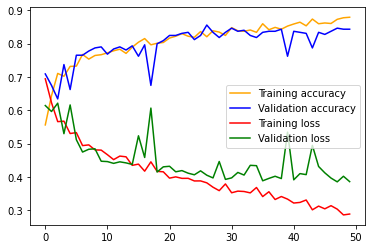

Path Test


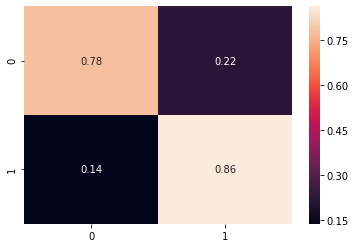

              precision    recall  f1-score   support

     Finding       0.83      0.78      0.80       184
      Normal       0.82      0.86      0.84       216

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Path Validate


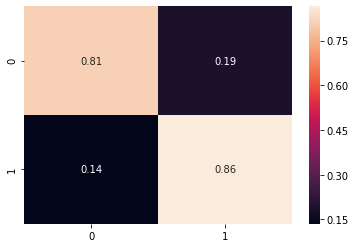

              precision    recall  f1-score   support

     Finding       0.80      0.81      0.81       128
      Normal       0.87      0.86      0.87       192

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320

INFO:tensorflow:Assets written to: model\heart\vgg16\HEART_0\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 16s 12ms/sample - loss: 0.6853 - accuracy: 0.5672 - val_loss: 0.6150 - val_accuracy: 0.7281
Epoch 2/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.6163 - accuracy: 0.6672 - val_loss: 0.5900 - val_accuracy: 0.7281
Epoch 3/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5742 - accuracy: 0.7109 - val_loss: 0.5620 - val_accuracy: 0.7312
Epoch 4/50
1280/1280 [===========

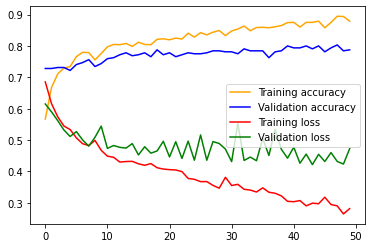

Path Test


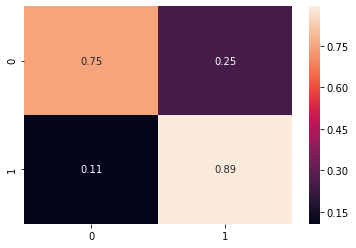

              precision    recall  f1-score   support

     Finding       0.86      0.75      0.80       184
      Normal       0.81      0.89      0.85       216

    accuracy                           0.83       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.83      0.83       400

Path Validate


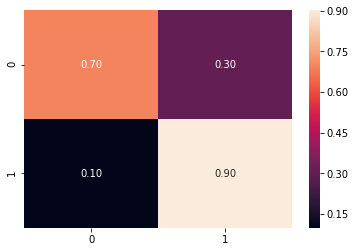

              precision    recall  f1-score   support

     Finding       0.90      0.70      0.78       178
      Normal       0.70      0.90      0.79       142

    accuracy                           0.79       320
   macro avg       0.80      0.80      0.79       320
weighted avg       0.81      0.79      0.79       320

INFO:tensorflow:Assets written to: model\heart\vgg16\HEART_1\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 16s 12ms/sample - loss: 0.7032 - accuracy: 0.5508 - val_loss: 0.6103 - val_accuracy: 0.6875
Epoch 2/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.6177 - accuracy: 0.6477 - val_loss: 0.5701 - val_accuracy: 0.7063
Epoch 3/50
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.5845 - accuracy: 0.7023 - val_loss: 0.5493 - val_accuracy: 0.7094
Epoch 4/50
1280/1280 [===========

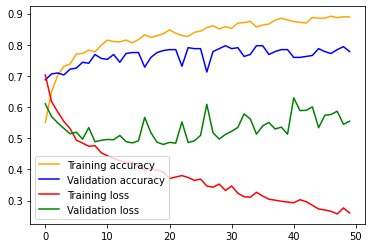

Path Test


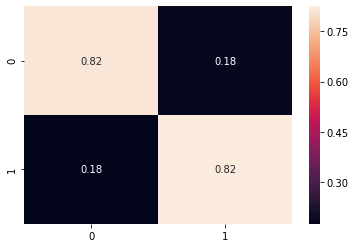

              precision    recall  f1-score   support

     Finding       0.80      0.82      0.81       184
      Normal       0.84      0.82      0.83       216

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Path Validate


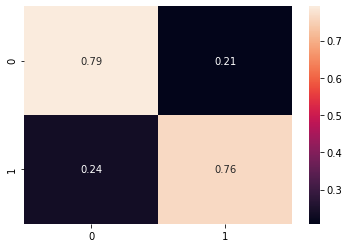

              precision    recall  f1-score   support

     Finding       0.79      0.79      0.79       168
      Normal       0.77      0.76      0.77       152

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320

INFO:tensorflow:Assets written to: model\heart\vgg16\HEART_2\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 16s 12ms/sample - loss: 0.6969 - accuracy: 0.5711 - val_loss: 0.6230 - val_accuracy: 0.6719
Epoch 2/50
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.5954 - accuracy: 0.6852 - val_loss: 0.6182 - val_accuracy: 0.6500
Epoch 3/50
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.5783 - accuracy: 0.7023 - val_loss: 0.5391 - val_accuracy: 0.7469
Epoch 4/50
1280/1280 [===========

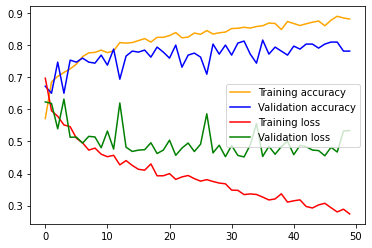

Path Test


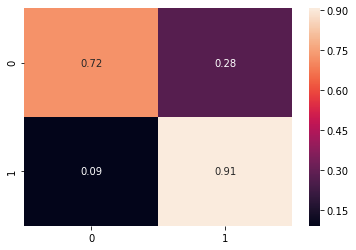

              precision    recall  f1-score   support

     Finding       0.87      0.72      0.79       184
      Normal       0.79      0.91      0.85       216

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

Path Validate


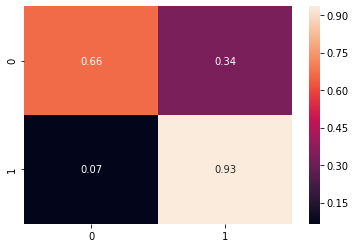

              precision    recall  f1-score   support

     Finding       0.93      0.66      0.78       182
      Normal       0.68      0.93      0.79       138

    accuracy                           0.78       320
   macro avg       0.80      0.80      0.78       320
weighted avg       0.82      0.78      0.78       320

INFO:tensorflow:Assets written to: model\heart\vgg16\HEART_3\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 16s 12ms/sample - loss: 0.6882 - accuracy: 0.5609 - val_loss: 0.6473 - val_accuracy: 0.5781
Epoch 2/50
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.6006 - accuracy: 0.6945 - val_loss: 0.6239 - val_accuracy: 0.6031
Epoch 3/50
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.5645 - accuracy: 0.7234 - val_loss: 0.5747 - val_accuracy: 0.7125
Epoch 4/50
1280/1280 [===========

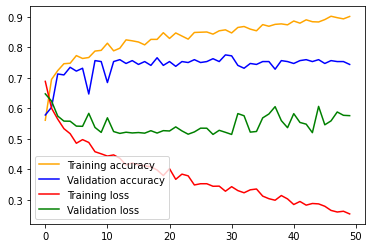

Path Test


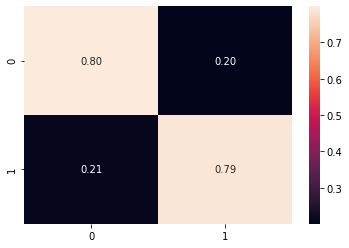

              precision    recall  f1-score   support

     Finding       0.77      0.80      0.78       184
      Normal       0.82      0.79      0.81       216

    accuracy                           0.80       400
   macro avg       0.79      0.80      0.79       400
weighted avg       0.80      0.80      0.80       400

Path Validate


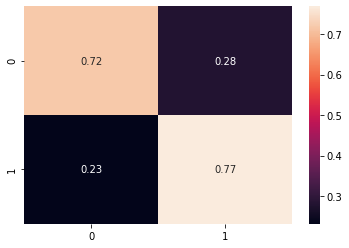

              precision    recall  f1-score   support

     Finding       0.76      0.72      0.74       160
      Normal       0.73      0.77      0.75       160

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320

INFO:tensorflow:Assets written to: model\heart\vgg16\HEART_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


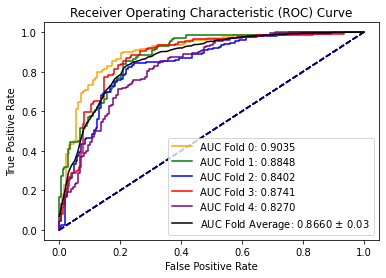

In [43]:
idk(heart_images, normal_images,"HEART")

In [49]:
from sklearn.model_selection import KFold
def vgg_19(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        
        #class
        
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        
        recv_fpr,recv_tpr,recv_acc = vgg19_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Average test accuracy:  0.809125
Average test loss:  0.4113426064681262


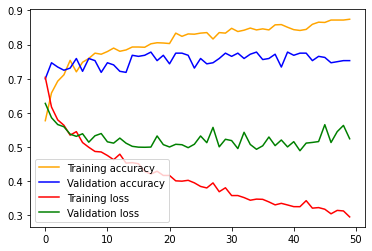

Path Test


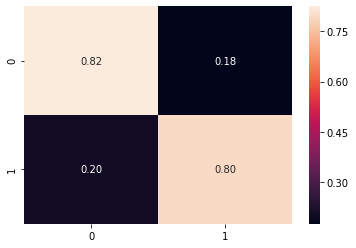

              precision    recall  f1-score   support

     Finding       0.79      0.82      0.81       194
      Normal       0.83      0.80      0.81       206

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

Path Validate


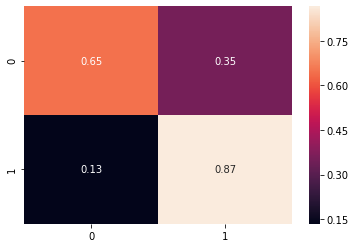

              precision    recall  f1-score   support

     Finding       0.83      0.65      0.73       164
      Normal       0.70      0.87      0.77       156

    accuracy                           0.75       320
   macro avg       0.77      0.76      0.75       320
weighted avg       0.77      0.75      0.75       320

INFO:tensorflow:Assets written to: model\heart\vgg19\HEART_0\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Average test accuracy:  0.79565626
Average test loss:  0.43131418275460603


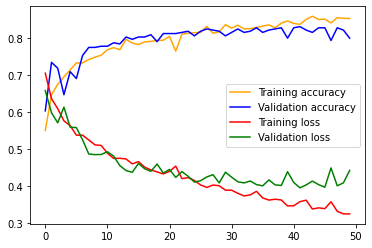

Path Test


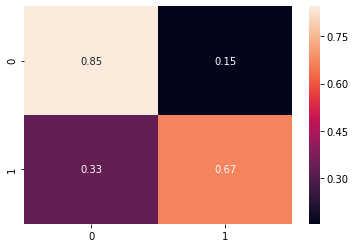

              precision    recall  f1-score   support

     Finding       0.71      0.85      0.77       194
      Normal       0.82      0.67      0.74       206

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.75       400
weighted avg       0.77      0.76      0.75       400

Path Validate


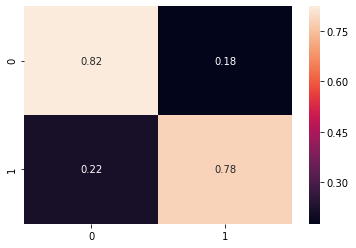

              precision    recall  f1-score   support

     Finding       0.74      0.82      0.78       136
      Normal       0.86      0.78      0.82       184

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.81      0.80      0.80       320

INFO:tensorflow:Assets written to: model\heart\vgg19\HEART_1\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Average test accuracy:  0.8202812
Average test loss:  0.4010205352269112


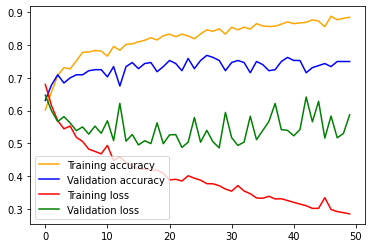

Path Test


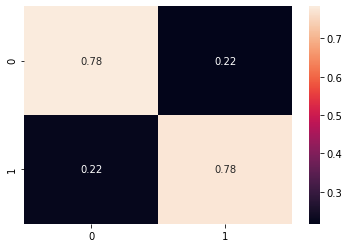

              precision    recall  f1-score   support

     Finding       0.77      0.78      0.78       194
      Normal       0.79      0.78      0.78       206

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400

Path Validate


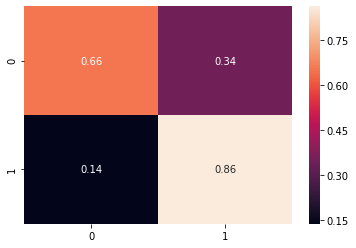

              precision    recall  f1-score   support

     Finding       0.85      0.66      0.74       174
      Normal       0.68      0.86      0.76       146

    accuracy                           0.75       320
   macro avg       0.76      0.76      0.75       320
weighted avg       0.77      0.75      0.75       320

INFO:tensorflow:Assets written to: model\heart\vgg19\HEART_2\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Average test accuracy:  0.7959375
Average test loss:  0.4332154315337538


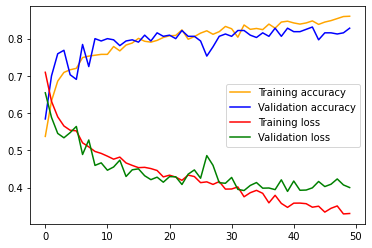

Path Test


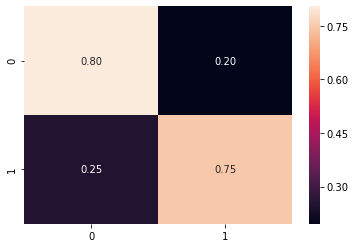

              precision    recall  f1-score   support

     Finding       0.75      0.80      0.78       194
      Normal       0.80      0.75      0.77       206

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.77       400
weighted avg       0.78      0.78      0.77       400

Path Validate


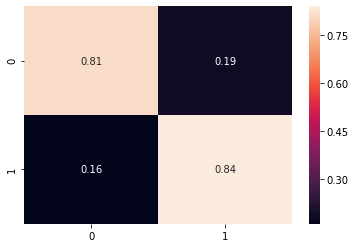

              precision    recall  f1-score   support

     Finding       0.83      0.81      0.82       156
      Normal       0.83      0.84      0.83       164

    accuracy                           0.83       320
   macro avg       0.83      0.83      0.83       320
weighted avg       0.83      0.83      0.83       320

INFO:tensorflow:Assets written to: model\heart\vgg19\HEART_3\assets
number of sample Train: 640
number of sample Test: 200
number of sample Val: 160
Average test accuracy:  0.80807817
Average test loss:  0.40638400371745226


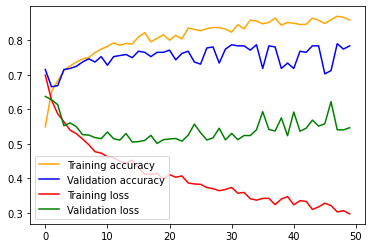

Path Test


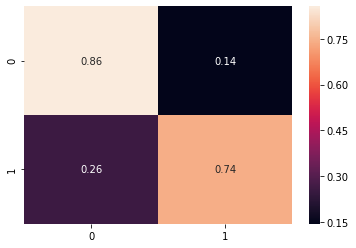

              precision    recall  f1-score   support

     Finding       0.76      0.86      0.80       194
      Normal       0.85      0.74      0.79       206

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

Path Validate


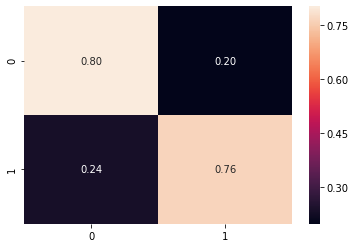

              precision    recall  f1-score   support

     Finding       0.81      0.80      0.80       176
      Normal       0.76      0.76      0.76       144

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320

INFO:tensorflow:Assets written to: model\heart\vgg19\HEART_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


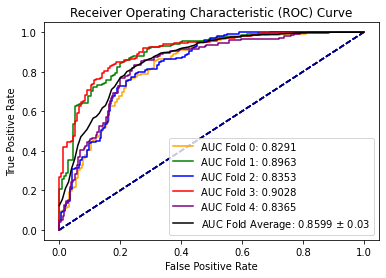

In [50]:
vgg_19(heart_images, normal_images,"HEART")